# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [61]:
import sys
sys.path.append('../')

from data import EMSelfPlay
from custom_transforms import RandomCutOut, GaussianBlur
from utils import show_sample, show_result, get_inpainting_transforms
from enum import Enum
from model import DynamicUnet
import numpy as np

# import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

In [17]:
# Computer SPECS
gpu_id = 1
num_cores = 4
torch.cuda.set_device(gpu_id)

## DATA

In [18]:
# hyper parameters
bs = 8  # batch size
size = 512  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')

In [19]:
config = {'min_n_holes': 10, 'max_n_holes': 15, 
          'min_size': 5, 'max_size': 10}


size = 512
tfms = get_inpainting_transforms(size, config=config)
print(tfms)

{'x': Compose(
    ToGrayScale(3)
    CenterCrop(size=(512, 512))
    RandomCutOut(10, 15, 5, 5)
    ToTensor()
), 'y': Compose(
    ToGrayScale(1)
    CenterCrop(size=(512, 512))
    ToTensor()
)}


In [20]:
class SimCLRDataTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj
    
    
    def __repr__(self):
        return f'{self.__class__.__name__}()'

In [47]:
def get_simclr_transforms(size, degrees=(-45, 45)):
    # get a set of data augmentation transformations as described in the SimCLR paper.
    tfms = transforms.Compose([transforms.CenterCrop(size=size),
                               transforms.RandomRotation(degrees=degrees),
                               transforms.RandomHorizontalFlip(),
                               RandomCutOut(20, 30, 10, 25),
                               GaussianBlur(kernel_size=int(0.1 * size)),
                               transforms.ToTensor()])
    return tfms

In [48]:
tfms = get_simclr_transforms(512)
tfms

Compose(
    CenterCrop(size=(512, 512))
    RandomRotation(degrees=(-45, 45), resample=False, expand=False)
    RandomHorizontalFlip(p=0.5)
    RandomCutOut(20, 30, 10, 10)
    ToTensor()
)

In [49]:
class EMSimCLR(Dataset):
    """A PyTorch Dataset class for self-supervised learning 
    on Electro-magnetic Microscopy Images.
    
    :param data_pth: Path object containing the absolute path to the target images
    :param transforms: Dictionary of transformations for the input and target images. 
    
    The transforms for the inputs defines the self-supervised pre-text task.
    See get_selfplay_transforms() in utils.py for an example definition.
    """

    def __init__(self, data_pth, transforms=None):
        self.img_filepaths = list(data_pth.glob('*.tif'))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_filepaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_filepaths[idx]
        y = Image.open(img_name)
        xi, xj = SimCLRDataTransform(self.transforms)(y)
        return xi, xj

In [50]:
clr_dataset = EMSimCLR(data_pth, transforms=tfms)

In [51]:
clr_dataloader = DataLoader(clr_dataset, batch_size=4,
                            shuffle=True, num_workers=4)

In [52]:
# %debug
xi, xj = clr_dataset[2]

In [53]:
xi.shape

torch.Size([3, 512, 512])

In [54]:
xj.shape

torch.Size([3, 512, 512])

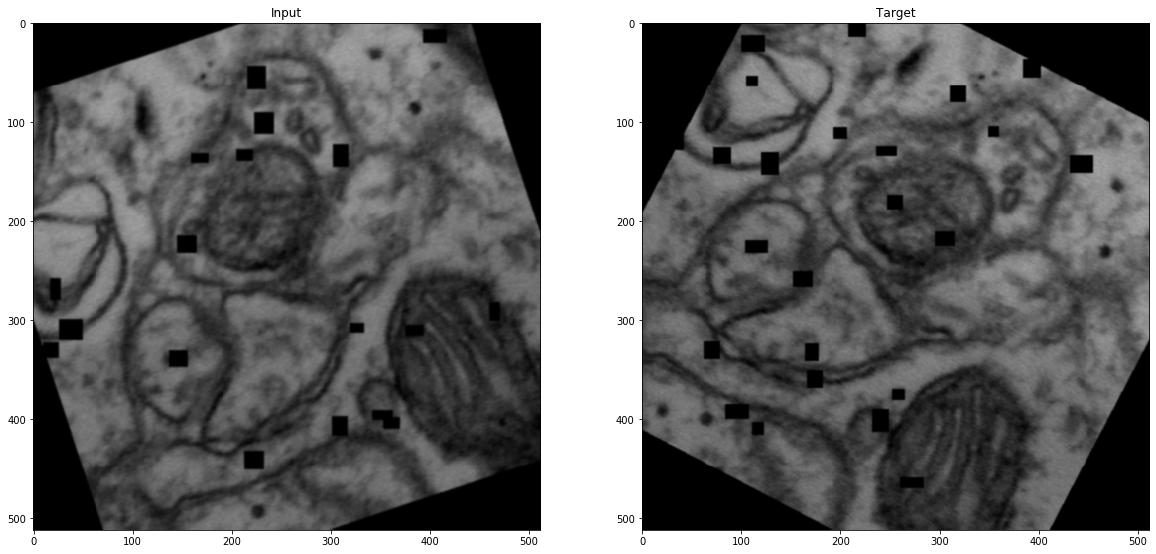

In [55]:
show_sample(clr_dataset)

## MODEL

In [56]:
arch = models.resnet34(False)

# encoder = nn.Sequential(*list(arch.children())[:-1])
arch.fc.in_features

512

In [57]:
class ResNetSimCLR(nn.Module):

    def __init__(self, out_dim, pretrained=False):
        super(ResNetSimCLR, self).__init__()
        resnet = models.resnet34(pretrained)
        num_ftrs = resnet.fc.in_features

        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # projection MLP
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
            print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)
        return h, x

In [58]:
model = ResNetSimCLR(512)
model

ResNetSimCLR(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## TRAINING

In [59]:
class NTXentLoss(nn.Module):
    """Loss function for Simple Contrastive Learning of Visual Representations"""
    def __init__(self, device, batch_size, temperature, 
                 use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [60]:
loss_function = NTXentLoss('cuda', 8, 0.5, True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [65]:
num_epochs = 1
print_every = 10
running_loss = 0.0
model.cuda()
for i in range(num_epochs):
    for j, sample_batch in enumerate(clr_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        xis, xjs = sample_batch
        xis = xis.cuda()
        xjs = xjs.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # get the representations and the projections
        ris, zis = model(xis)  # [N,C]

        # get the representations and the projections
        rjs, zjs = model(xjs)  # [N,C]

        # normalize projection feature vectors
        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

 
        loss = loss_function(zis, zjs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if j % (print_every) == 0:
            print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
            running_loss = 0.0

> <ipython-input-59-73ecc313c043>(52)forward()
     50         l_pos = torch.diag(similarity_matrix, self.batch_size)
     51         r_pos = torch.diag(similarity_matrix, -self.batch_size)
---> 52         positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)
     53 
     54         negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

ipdb> l_pos
tensor([], device='cuda:1', grad_fn=<DiagBackward>)
ipdb> similarity_matrix
tensor([[1.0000, 0.8860, 0.9089, 0.9951, 0.9946, 0.8947, 0.9839, 0.9926],
        [0.8860, 1.0000, 0.9921, 0.8744, 0.9089, 0.9966, 0.9361, 0.9204],
        [0.9089, 0.9921, 1.0000, 0.8981, 0.9294, 0.9919, 0.9564, 0.9402],
        [0.9951, 0.8744, 0.8981, 1.0000, 0.9929, 0.8826, 0.9792, 0.9899],
        [0.9946, 0.9089, 0.9294, 0.9929, 1.0000, 0.9165, 0.9877, 0.9948],
        [0.8947, 0.9966, 0.9919, 0.8826, 0.9165, 1.0000, 0.9398, 0.9269],
        [0.9839, 0.9361, 0.9564, 0.9792, 0.9877, 0.9398, 1.0000, 0.9916],
 

RuntimeError: shape '[16, 1]' is invalid for input of size 0

In [64]:
torch.diag()

torch.Size([4, 512])

## Inference

In [28]:
x, y = inpaint_dataset[32000]

In [36]:
model.eval();
pred = model(x.unsqueeze(0).cuda())

In [52]:
pred.permute(3,2,0,1).squeeze()

tensor([[0.4476, 0.5348, 0.5297,  ..., 0.5380, 0.5561, 0.3788],
        [0.5137, 0.6137, 0.5727,  ..., 0.5611, 0.6021, 0.5166],
        [0.7518, 1.0160, 0.7877,  ..., 0.5731, 0.5893, 0.6153],
        ...,
        [0.6684, 0.9183, 0.7371,  ..., 0.4335, 0.3497, 0.3440],
        [0.5774, 0.8920, 0.6092,  ..., 0.4359, 0.4312, 0.3508],
        [0.4017, 0.6966, 0.5627,  ..., 0.4107, 0.4181, 0.2655]],
       device='cuda:1', grad_fn=<SqueezeBackward0>)

In [46]:
y.shape

torch.Size([1, 512, 512])

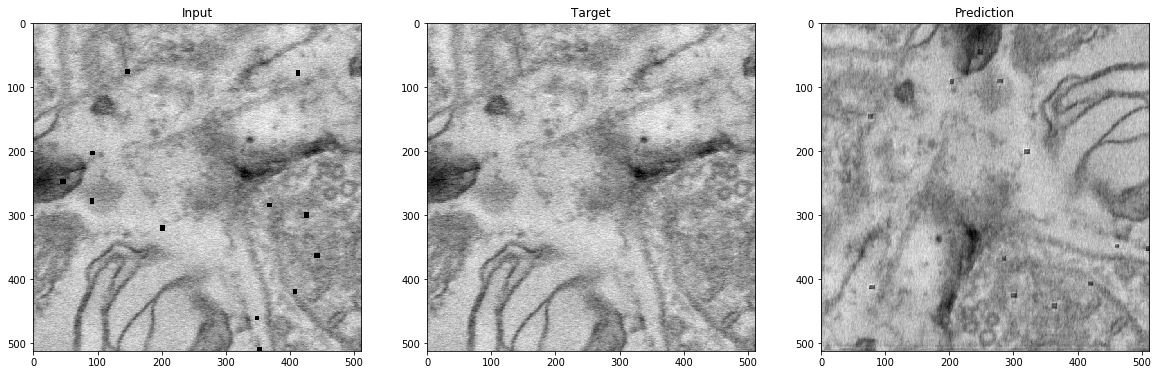

In [54]:
show_result(x, y, pred)